In [110]:
from IPython.display import Markdown as md
from IPython.display import display_markdown as dm
import numpy as np
from numpy.linalg import norm
# import pandas as pd
import matplotlib.pyplot as plt
import sympy as smp
import scipy as scp
from scipy.interpolate import interp1d

(np.float64(1.6780941570722423),
 np.float64(0.23571443501861658),
 np.float64(0.17678582626396244),
 np.float64(0.20976176963403032),
 np.float64(0.29409822748571246),
 np.float64(0.1838113921785703),
 np.float64(0.021295984770132895))

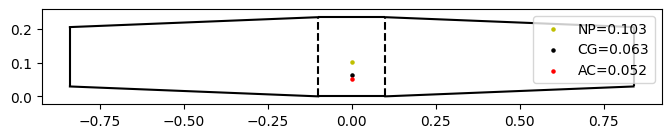

In [202]:
class UAV:
    __rho0 = 1.225
    rho = __rho0
    __g = 9.81
    __mu = 0.0289644
    __R = 8.3144598
    T = 273 + 15
    __visc = 18e-6
    def __init__(self, mass, V, CGposition, WingData, FusWidth, FusLength, Tail, cr=0, SweepQuart = True, H = 0):
        self.Va = V
        self.H = H
        self.__mass = mass
        self.W = self.__mass * self.__g
        self.S = WingData[1]
        self.d = FusWidth
        self.L = FusLength
        self.FusS = 0.3 # Надо изменить 

        self.__Ttype = Tail[0] # тип хвостового оперения 
        self.__Vht = Tail[2] # объемные коэффициенты хвостового оперения
        self.__Vvt = Tail[3]
        self.__Lt = Tail[4] # длина балки хвостового оперения (плечо хвоста) (между четвертями хорд)
        self.ART = 2 # Удлинение хвоствого оперения 
        self.TRT = 0.6 # сужение хвостового оперения

        self.__hac = 0.25 # расстояние от передней кромки крыла в ед САХ до аэродинамич центра 
        self.__hcg = CGposition # расстояние от передней кромки крыла в ед САХ до центра тяжести

        # Расчет размера крыла ###############################################
        if (cr == 0):
            self.AR = WingData[3]
            self.TR = WingData[2]
            self.c = np.sqrt(self.S/self.AR)
            self.b = self.S/self.c
            self.cr = self.S / (self.d + (1 + self.TR)*(self.b - self.d)/2)
            self.ct = self.cr * self.TR

        elif (cr != 0):
            self.AR = WingData[3]
            self.cr = WingData[4]
            self.c = np.sqrt(self.S/self.AR)
            self.b = self.S/self.c
            self.ct = 2*(self.S - self.cr*self.d)/(self.b - self.d) - self.cr
            self.TR = self.ct/self.cr
            if (self.TR >= 1):
                self.TR = 1
                self.c = np.sqrt(self.S/self.AR)
                self.ct = self.c
                self.cr = self.ct

        ex = np.array([1., 0])
        ey = np.array([0, 1.])
        if (SweepQuart == False):
            a = 3/4*self.cr * ex + ey * 0.5 * (self.b - self.d) + ex*1/4*self.ct - ex*self.cr
            b = 3/4*self.cr * ex + ey * 0.5 * (self.b - self.d) - ex * 3/4*self.ct
            e = b + ex*0.5*self.ct
    
            self.SweepLE = np.acos(np.dot(ey, a) / (norm(a) * norm(ey)))
            self.SweepTE = np.acos(np.dot(ey, b) / (norm(b) * norm(ey)))

            self.SweepHalf = np.acos(np.dot(ey, e - ex*0.5*self.cr) / (norm(e - ex*0.5*self.cr) * norm(ey)))
            self.SweepQuart = 0
        elif (SweepQuart == True):
            self.SweepLE = np.atan((self.cr - self.ct) / (self.b - self.d))
            self.SweepQuart = np.tan(self.SweepLE) + self.cr*0.5/(self.b - self.d) * (self.TR - 1)
            self.SweepHalf = 0

        self.__Swet = 2*self.S - 2 * (self.d * self.cr)
        #########################################################################################

        # Расчет размера хвоствого оперения #####################################################
        self.Sht = self.__Vht * self.c * self.S / self.__Lt
        self.Svt = self.__Vvt * self.b * self.S / self.__Lt
        if (self.__Ttype == 'V'):
            self.Stail = self.Sht + self.Svt
            self.DihedraTail = np.atan(self.Svt/self.Sht) # rad
        self.btail = np.sqrt(self.Stail / 2  * self.ART)
        self.ctail = self.btail / self.ART
        self.crtail = 2 * self.ctail / (1 + self.TRT)
        self.cttail = self.TRT * self.crtail

        self.SweepLEtail = np.atan((self.crtail - self.cttail) / self.btail)
        self.SweepQuarttail = np.atan( 3 * (self.crtail - self.cttail) / (4 * self.btail))
        self.SweepHalftail = np.atan( (-self.cttail + self.crtail) / (2 * self.btail) )

        self.__Swettail = self.Stail * 2 # Полная площадь хвостового оперения
        #########################################################################################

        self.airfoilW = WingData[0]
        self.airfoilWDat = np.loadtxt('{}.txt'.format(self.airfoilW), skiprows = 11, dtype=float)
        self.xtop = self.airfoilWDat[:, 5]
        self.xbot = self.airfoilWDat[:, 6]
        self.AOA = self.airfoilWDat[:, 0] - np.ones(len(self.airfoilWDat[:, 0]))*WingData[-1] 
        self.fxtop = interp1d(self.AOA, self.xtop) # интерполяционные функции для точки перехода
        self.fxbot = interp1d(self.AOA, self.xbot) # от ламинарного к турбулентному течению в зависимости от угла атаки

        self.airfoilWGeo = np.loadtxt('{}G.txt'.format(self.airfoilW), skiprows=1, dtype=float)
        self.thick = self.airfoilWGeo[0]
        self.thickLoc = self.airfoilWGeo[1]
        self.cam = self.airfoilWGeo[2]
        self.camLoc = self.airfoilWGeo[3]

        self.airfoilT = Tail[1] # Профиль хвостового оперения
        self.airfoilTDat = np.loadtxt('{}.txt'.format(self.airfoilT), skiprows = 11, dtype=float)
        self.xtopT = self.airfoilTDat[:, 5]
        self.xbotT = self.airfoilTDat[:, 6]
        self.AOAT = self.airfoilTDat[:, 0] - np.ones(len(self.airfoilTDat[:, 0]))*Tail[-1] * np.cos(self.DihedraTail)
        self.fxtopT = interp1d(self.AOAT, self.xtopT) # интерполяционные функции для точки перехода
        self.fxbotT = interp1d(self.AOAT, self.xbotT) # от ламинарного к турбулентному течению в зависимости от угла атаки

        self.airfoilTGeo = np.loadtxt('{}G.txt'.format(self.airfoilT), skiprows=1, dtype=float)
        self.thickT = self.airfoilTGeo[0]
        self.thickLocT = self.airfoilTGeo[1]
        self.camT = self.airfoilTGeo[2]
        self.camLocT = self.airfoilTGeo[3]

        self.__GetAirDensity(H)

        # Параметры управляющих поверхностей #############################################
        # TailData = (type, TailAirfoil, Vht, Vvt, Lt, cf, etaitail, etaetail, itail)
        # WingData = (WingAirfoil, S, TR, AR, cr, cf, etai, etae, iw)
        self.cfw = WingData[5] # доля хорды крыла на элероны
        self.cft = Tail[5] # доля хорды хвосового оперения на rudevator
        self.etai = WingData[6]
        self.etae = WingData[7]
        self.etaiT = Tail[6]
        self.etaeT = Tail[7]

        # Теоретический наклон кривой подъемного коэфф для профиля в зависимости от толщины
        thickness = [0, 0.6, 0.10, 0.14, 0.18, 0.2]
        clath = [6.3, 6.59, 6.79, 6.99, 7.19, 7.3]
        self.fClath = interp1d(thickness, clath)

        # Теоретическое значение dCl/ddelta
        thickness02 = [0, 0.04, 0.1, 0.15]
        thickness03 = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.15]
        cldth02 = [3.4, 3.55, 3.625, 3.75]
        cldth025 = [3.8, 3.875, 4.1, 4.25]
        cldth03 = [4.155, 4.229, 4.283, 4.352, 4.406, 4.465, 4.549, 4.609]
        
        self.Cldelta02 = interp1d(thickness02, cldth02)
        self.Cldelta025 = interp1d(thickness02, cldth025)
        self.Cldelta03 = interp1d(thickness03, cldth03)
        
        # Отношение реальной к теоретической dCl/ddelta
        Cldeltaratio02 = np.loadtxt('CldeltaRatio02.csv', skiprows=1, dtype=float, delimiter=',')[:, 3] + 0.3
        Cldeltaratio025 = np.loadtxt('CldeltaRatio025.csv', skiprows=1, dtype=float, delimiter=',')[:, 3] + 0.3
        Cldeltaratio03 = np.loadtxt('CldeltaRatio03.csv', skiprows=1, dtype=float, delimiter=',')[:, 3] + 0.3
        claRatio = np.linspace(0.7, 1, 16)

        self.CldeltaRatio02 = interp1d(claRatio, Cldeltaratio02)
        self.CldeltaRatio025 = interp1d(claRatio, Cldeltaratio025)
        self.CldeltaRatio03 = interp1d(claRatio, Cldeltaratio03)

        # Коэффициент отклонения рулей для профиля
        K02 = np.loadtxt('AirfoilFlapCoeff02.csv', dtype=float, delimiter=',', skiprows=1)[:,3]
        K025 = np.loadtxt('AirfoilFlapCoeff025.csv', dtype=float, delimiter=',', skiprows=1)[:,3]
        K03 = np.loadtxt('AirfoilFlapCoeff03.csv', dtype=float, delimiter=',', skiprows=1)[:,3]
        deflection = np.linspace(0, 40, 9)

        self.fK02 = interp1d(deflection, K02)
        self.fK025 = interp1d(deflection, K025)
        self.fK03 = interp1d(deflection, K03)

        # Коэффициент отклонения рулей для секции
        Kb = np.loadtxt('KbFlapTR05.csv', delimiter=',', dtype=float, skiprows=1)[:,3]
        eta = np.linspace(0, 1, 21)
        self.fKb = interp1d(eta, Kb)
        ##################################################################################

    def __GetAirDensity(self, h):
        self.rho = self.__rho0*np.exp(-self.__g * self.__mu * h / (self.__R * self.T))

    def GetReynolds(self, type, x = 0):
        '''Возвращае число Рейнольдса

        "MeanW" - для САХ,

        "RootW" - для корневой хорды,

        "TipW" - для концевой хорды,

        "LocalW" - для расстояния x от передней кромки крыла или
        фюзеляжа,

        "Fus" - для фюзеляжа,  

        "RootT" - для корневой хорды хвоста,

        "TipT" - для концевой хорды хвоста,

        "MeanT" - для САХ хвоста

        Если число Рейнольдса превышает число Рейнольдса отрыва

        Recutoff = 38.21(c/k)**1.053

        (см. General Aviation Aircraft Design стр.682, формула (16-31))

        для поверхности c характерной норовностью k, то учитывается оно'''
        kcomp = 0.2e-5 * 0.3048 # Композит
        k3d = 20e-6 # для 3д принтера 20 мкм не обработаная поверхность перпендикулярон слоям
    
        if type == 'MeanW':
            Recoff = 38.21*(self.c/kcomp)**1.053
            R = self.rho * self.Va * self.c / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R 
            
        if type == 'RootW':
            Recoff = 38.21*(self.cr/kcomp)**1.053
            R = self.rho * self.Va * self.cr / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R
            
        if type == 'TipW':
            Recoff = 38.21*(self.ct/kcomp)**1.053
            R = self.rho * self.Va * self.ct / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R
            
        if type == 'Fus':
            Recoff = 38.21*(self.L/k3d)**1.053
            R = self.rho * self.Va * self.L / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R
        
        if type == 'LocalW':
            return self.rho * self.Va * x / self.__visc
        
        if type == 'RootT':
            Recoff = 38.21*(self.crtail/kcomp)**1.053
            R = self.rho * self.Va * self.crtail / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R 
            
        if type == 'TipT':
            Recoff = 38.21*(self.cttail/kcomp)**1.053
            R = self.rho * self.Va * self.cttail / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R 
            
        if type == 'MeanT':
            Recoff = 38.21*(self.ctail/kcomp)**1.053
            R = self.rho * self.Va * self.ctail / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R 
        
    def __GetSkinFriction(self, type, side, AOA):
        '''Функция считает коэффициент силы трения в приближении
        турбулентного-ламинароного обтекания тела при угле атаки AOA в градусах
        
        'Fus' - для фюзеляжа,

        "MeanW" - для САХ,

        "RootW" - для корневой хорды,

        "TipW" - для концевой хорды,

        "RootT" - для корневой хорды хвоста,

        "TipT" - для концевой хорды хвоста,

        "MeanT" - для САХ хвоста
        '''
        Re = self.GetReynolds(type)
        if (type[-1] == 'T'):
            if side == 'Top':
                x0 = 36.9*self.fxtopT(AOA * np.cos(self.DihedraTail))**0.625 * (1/Re)**0.375
                return 0.074/(Re**0.2) * (1 - (self.fxtopT(AOA* np.cos(self.DihedraTail)) - x0))**0.8
            elif side == 'Bottom':
                x0 = 36.9*self.fxbotT(AOA* np.cos(self.DihedraTail))**0.625 * (1/Re)**0.375
                return 0.074/(Re**0.2) * (1 - (self.fxbotT(AOA* np.cos(self.DihedraTail)) - x0))**0.8

        elif (type != 'Fus'):
            if side == 'Top':
                x0 = 36.9*self.fxtop(AOA)**0.625 * (1/Re)**0.375
                return 0.074/(Re**0.2) * (1 - (self.fxtop(AOA) - x0))**0.8
            elif side == 'Bottom':
                x0 = 36.9*self.fxbot(AOA)**0.625 * (1/Re)**0.375
                return 0.074/(Re**0.2) * (1 - (self.fxbot(AOA) - x0))**0.8
        else:
            x0 = 36.9 * 0.05**0.625 * (1/Re)**0.375
            return 0.074/(Re**0.2) * (1 - (0.05 - x0))**0.8

    def GetCDmin(self, crud = 1.25, AOA = 0):
        '''Функция подсчитывает минимальный коэффициент лобового сопротивления для всего самолета
        на основе геометрических характеристик крыла, хвостового оперения и фюзеляжа'''
        # Сопротивление крыла #################
        Ctip = 0.5 * (self.__GetSkinFriction(type='TipW', side='Top', AOA = AOA) + self.__GetSkinFriction(type='TipW', side='Bottom', AOA = AOA))
        Croot = 0.5 * (self.__GetSkinFriction(type='RootW', side='Top', AOA = AOA) + self.__GetSkinFriction(type='RootW', side='Bottom', AOA = AOA))
        Cfw = 0.5 * (Croot + Ctip)
        Cdw = self.__Swet / self.S * Cfw

        # if (abs(self.thickLoc - 0.3) <=0.05):
        #     FFw = 1 + 2*(self.thick) + 60(self.thick)**4
        # elif (self.thickLoc >= 0.4 and self.thickLoc <= 0.5):
        #     FFw = 1 + 1.2*(self.thick) + 70(self.thick)**4
        FFw = (3.3*(self.thick) - 0.008*(self.thick)**2 + 27*(self.thick)**3)*(np.cos(self.SweepHalf))**2 + 1
        IFw = 1.05
        Cdw = FFw * Cdw * IFw
        #######################################

        # Сопротивление фюзеляжа ##############
        f = self.L/2 * np.sqrt(4 / self.d**2)
        ReF = self.GetReynolds(type='Fus')
        if (ReF <= 1e5):
            Cdf = 1.328/(ReF)**0.5 * (1 + f**-1.5) + 0.11*f**-2
        elif (ReF > 1e5):
            FFf1 = 1 + 1.5*f**-1.5 + 7*f**-3
            FFf2 = 1 + 2.2*f**-1.5 + 3.8*f**-3

            FFf3 = 1 + 60*f**-3 + f/400 #This provides a good correlation for fineness ratios 
            #(f) above 6 as is typical for high-speed and military aircraft, but 
            #seems to overestimate drag for fineness ratios much below 5.

            FFf4 = 2.939 - 0.7666*f + 0.1328*f**2 - 0.01074*f**3 + 3.275e-4*f**4
            FFf5 = 1 + 2.2*f**-1.5 - 0.9*f**-3
            FFf6 = 0.9 + 5*f**-1.5 + f/400 # From Raymer

            FFf = np.mean([FFf1, FFf2, FFf3, FFf4, FFf5, FFf6])
        IFf = 1.0
        Cdf = self.__GetSkinFriction(type='Fus', side = 'Top', AOA=AOA) * FFf * (self.FusS) / self.S * IFf
        #######################################

        # Сопротивление хвостового оперения ##################
        Ctiptail = 0.5 * (self.__GetSkinFriction(type='TipT', side='Top', AOA = AOA) + self.__GetSkinFriction(type='TipT', side='Bottom', AOA = AOA))
        Croottail = 0.5 * (self.__GetSkinFriction(type='RootT', side='Top', AOA = AOA) + self.__GetSkinFriction(type='RootT', side='Bottom', AOA = AOA))
        Cft = 0.5 * (Croottail + Ctiptail)
        Cdt = self.__Swettail / self.S * Cft
        FFt = (3.3*(self.thickT) - 0.008*(self.thickT)**2 + 27*(self.thickT)**3)*(np.cos(self.SweepHalftail))**2 + 1
        IFt = 1.03
        Cdt = IFt * Cdt * FFt
        ######################################################

        return (Cdf + Cdw + Cdt)*crud

    def GetAirfoilCl(self, AOA, type):
        '''Возвращает значение коэффициента подъемной
        силы профиля для заданного угла атаки
        type = "Wing" - для профиля крыла
        type = "Tail" - для профиля хвоста'''
        if (type == "Wing"):
            alpha = self.AOA
            Cl = self.airfoilWDat[:, 1]
            fCl = interp1d(alpha, Cl)
            return fCl(AOA)
        elif (type == "Tail"):
            alpha = self.AOAT
            Cl = self.airfoilTDat[:, 1]
            fCl = interp1d(alpha, Cl)
            return fCl(AOA * np.cos(self.DihedraTail))
    
    def GetAirfoilCd(self, AOA, type):
        '''Возвращает значение коэффициента силы 
        лобового сопротивления профиля для заданного угла атаки
        type = "Wing" - для профиля крыла
        type = "Tail" - для профиля хвоста'''
        if (type == "Wing"):
            alpha = self.AOA
            Cd = self.airfoilWDat[:, 2]
            fCd = interp1d(alpha, Cd)
            return fCd(AOA)
        elif (type == "Tail"):
            alpha = self.AOAT
            Cd = self.airfoilTDat[:, 2]
            fCd = interp1d(alpha, Cd)
            return fCd(AOA * np.cos(self.DihedraTail))
    
    def GetAirfoilCd0(self, type):
        '''Возвращает значение коэффициента силы 
        лобового сопротивления профиля для 0 угла атаки
        type = "Wing" - для профиля крыла
        type = "Tail" - для профиля хвоста'''
        if (type == "Wing"):
            alpha = self.AOA
            Cd = self.airfoilWDat[:, 2]
            fCd = interp1d(alpha, Cd)
            return fCd(0)
        elif (type == "Tail"):
            alpha = self.AOAT
            Cd = self.airfoilTDat[:, 2]
            fCd = interp1d(alpha, Cd)
            return fCd(0)
    
    def GetAirfoilCdmin(self, type):
        cur = 10
        a = 0
        if (type == "Wing"):
            alpha = self.AOA
            Cd = self.airfoilWDat[:, 2]
            fCd = interp1d(alpha, Cd)
            for el in np.linspace(-5, 10, 10000):
                if (fCd(el) < cur):
                    cur = fCd(el)
                    a = el
            return (a, cur)
        elif (type == "Tail"):
            alpha = self.AOAT
            Cd = self.airfoilTDat[:, 2]
            fCd = interp1d(alpha, Cd)
            for el in np.linspace(-5, 10, 10000):
                if (fCd(el) < cur):
                    cur = fCd(el)
                    a = el
            return (a / self.DihedraTail, cur)
    
    def GetAirfoilCm(self, AOA, type):
        if (type == "Wing"):
            alpha = self.AOA
            Cm = self.airfoilWDat[:, 4]
            fCm = interp1d(alpha, Cm)
            return fCm(AOA)
        elif (type == "Tail"):
            alpha = self.AOAT
            Cm = self.airfoilTDat[:, 4]
            fCm = interp1d(alpha, Cm)
            return fCm(AOA * np.cos(self.DihedraTail))
    
    def GetAirfoilClmax(self, type):
        curr = 0
        a=0
        if (type == "Wing"):
            alpha = self.AOA
            Cl = self.airfoilWDat[:, 1]
            fCl = interp1d(alpha, Cl)
            for el in np.linspace(0, alpha[-1], 10000):
                if fCl(el) >= curr:
                    curr = fCl(el)
                    a = el
            return (a, curr)
        if (type == "Tail"):
            alpha = self.AOAT
            Cl = self.airfoilTDat[:, 1]
            fCl = interp1d(alpha, Cl)
            for el in np.linspace(0, alpha[-1], 10000):
                if fCl(el) >= curr:
                    curr = fCl(el)
                    a = el
            return (a / self.DihedraTail, curr)
    
    def GetAirfoilClslope(self, AOA, type):
        '''Возвращает наклон кривой подъеного коэффициента
        профиля в 1/рад'''
        if (type == "Wing"):
            alpha = self.AOA
            Cl = self.airfoilWDat[:, 1]
            fCl = interp1d(alpha, Cl)
            return (-fCl(AOA) + fCl(AOA + 0.1))/0.1 *180/np.pi
        elif (type == "Tail"):
            alpha = self.AOAT
            Cl = self.airfoilTDat[:, 1]
            fCl = interp1d(alpha, Cl)
            return (-fCl(AOA * self.DihedraTail) + fCl(AOA * self.DihedraTail + 0.1))/0.1 *180/np.pi
    
    def GetCLmax(self):
        '''Возвращает максимально достижимый коэффициент подъемной силы
        для крыла заданных размеров'''
        return 0.9 * np.cos(self.SweepQuart) * self.GetAirfoilClmax(type='Wing')[1]
    
    def GetAirfoilCl0(self, type):
        '''Возвращает коэффициент подъемной силы профиля
        при нулевом угле атаки'''
        if (type == 'Wing'):
            alpha = self.AOA
            Cl = self.airfoilWDat[:, 1]
            fCl = interp1d(alpha, Cl)
            return fCl(0)
        elif (type == 'Tail'):
            alpha = self.AOAT
            Cl = self.airfoilTDat[:, 1]
            fCl = interp1d(alpha, Cl)
            return fCl(0)

    def GetCL0(self, type):
         az = (-1)*self.GetAirfoilCl0(type=type)/self.GetAirfoilClslope(AOA=0, type=type)
         return abs(az)*self.GetCLslope(type)

    def GetZeroLiftAOA(self):
        return (-1)*self.GetAirfoilCl0(type="Wing")/self.GetAirfoilClslope(AOA=0, type="Wing")
    
    def GetCLcruise(self):
        return self.GetCL0('Wing') + self.W/(self.GetDynamicPressure() * self.S) + self.GetCLslope('Wing')*self.GetZeroLiftAOA()
    
    def GetDynamicPressure(self):
        self.__GetAirDensity(self.H)
        if self.Va != 0:
            return self.rho * self.Va**2 / 2
        else:
            return self.rho * self.GetCruiseSpeed()**2 / 2
    
    def GetSpeedSound(self):
        return np.sqrt(1.4 * self.__R * self.T/self.__mu)
    
    def GetCLslope(self, type, AOA=0):
        """Расчитывает наклон кривой коэффициента подъемной силы
        для секции крыла в 1/rad"""
        if (type == 'Wing'):
            beta = 1 - (self.Va/self.GetSpeedSound())**2
            k = self.GetAirfoilClslope(AOA=AOA, type=type) / (2*np.pi)
            x = self.AR/k * (beta**2 + np.tan(self.SweepHalf)**2)**0.5
            eta = 0.98
            return 2*np.pi*self.AR / (2 + np.sqrt(x**2 + 4))*eta
        elif (type == 'Tail'):
            beta = 1 - (self.Va/self.GetSpeedSound())**2
            k = self.GetAirfoilClslope(AOA=AOA, type=type) / (2*np.pi)
            x = self.ART/k * (beta**2 + np.tan(self.SweepHalftail)**2)**0.5
            eta = 0.98
            return 2*np.pi*self.ART / (2 + np.sqrt(x**2 + 4))*eta
    
    def GetOsvald(self, type, method = 'A'):
        if (type == 'Wing'):
            if (method == 'A'):
                return 2 / (2 - self.AR + np.sqrt(4 + self.AR**2*(1 + np.tan(self.SweepQuart))))
            if (method == 'B'):
                r = 0.38 - self.SweepLE * 57.3/3000 + (self.SweepLE * 57.3)**2/15000
                u = 0.98
                t = self.d / self.b
                CDmin = self.GetCDmin()
                return 1 / (np.pi*self.AR*r*CDmin + 1 / ((1 + 0.03*t - 2*t**2)*u))
        
        elif (type == 'Tail'):
            if (method == 'A'):
                return 2 / (2 - self.ART + np.sqrt(4 + self.ART**2*(1 + np.tan(self.SweepQuarttail))))
            if (method == 'B'):
                r = 0.38 - self.SweepLEtail * 57.3/3000 + (self.SweepLEtail * 57.3)**2/15000
                u = 0.98
                t = self.d / self.b
                CDmin = self.GetCDmin()
                return 1 / (np.pi*self.ART*r*CDmin + 1 / ((1 + 0.03*t - 2*t**2)*u))

            
    def GetTotalLiftCoefficient(self, AOA, deflecW, deflecT):
        CLw = self.GetCL0("Wing") + self.GetCLslope('Wing') * AOA/57.3
        CLdeltaw = self.GetCLdelta('Wing', deflecW, AOA)
        CLt = (self.GetCL0("Tail") + self.GetCLslope('Tail') * AOA/57.3 ) * np.cos(self.DihedraTail)
        CLdeltat = self.GetCLdelta('Tail', deflecT, AOA)

        CLtotal = CLw + CLdeltaw + self.Sht / self.S * (CLt + CLdeltat) # Брать отношение горизонтальной площади или всего хвоста?
        return CLtotal
    
    def GetCLmaxTotal(self):
        CLmw = self.GetCLmax()
        CLmt = 0.9 * np.cos(self.SweepQuarttail) * self.GetAirfoilClmax(type='Tail')[1] * self.Sht / self.S
        return CLmw + CLmt
    
    def GetStallSpeed(self):
        CLm = self.GetCLmaxTotal()
        return np.sqrt(2*self.W / (self.rho * self.S * CLm))
    
    def GetAirfoilCldelta(self, type, deflec, AOA):
        '''Функция принимает тип (type) поверхности, для которой необходимо
        расчитать производную коэфф подъемной силы профиля по отклонению рулей
        при заданном отклонении рулей на угол deflec. Положительный 
        соответствует отколонению рулей вниз
        
        type = 'Wing' - для крыла,
        
        type = 'Tail' - для хвостового оперения'''
        if (type == 'Wing'):
            Clatheory = self.fClath(self.thick)
            claRatio = self.GetAirfoilClslope(AOA=AOA, type=type) / Clatheory
            if (claRatio >1):
                claRatio = 1
            if (claRatio < 0.7):
                claRatio = 0.7

            if (abs(self.cfw - 0.2) < 0.025):
                CldeltaRatio = self.CldeltaRatio02(claRatio)
                Cldeltath = self.Cldelta02(self.thick)
                K = self.fK02(abs(deflec))
            elif (abs(self.cfw - 0.25) < 0.025):
                CldeltaRatio = self.CldeltaRatio025(claRatio)
                Cldeltath = self.Cldelta025(self.thick)
                K = self.fK025(abs(deflec))
            elif (abs(self.cfw - 0.3) < 0.025):
                CldeltaRatio = self.CldeltaRatio03(claRatio)
                Cldeltath = self.Cldelta03(self.thick)
                K = self.fK03(abs(deflec))
            return CldeltaRatio * Cldeltath * K * deflec/57.3
       
            
        elif (type == 'Tail'):
            Clatheory = self.fClath(self.thickT)
            # claRatio = self.GetAirfoilClslope(AOA=AOA, type=type) / Clatheory # из-за нелинейности профиля дает сбои
            # заменил на данные из DATCOM для отношения коэфф. подъемной силы профиля
            claRatio = 0.85
            if (claRatio > 1):
                claRatio = 1

            if (abs(self.cft - 0.2) < 0.025):
                CldeltaRatio = self.CldeltaRatio02(claRatio)
                Cldeltath = self.Cldelta02(self.thickT)
                K = self.fK02(abs(deflec))
            elif (abs(self.cft - 0.25) < 0.025):
                CldeltaRatio = self.CldeltaRatio025(claRatio)
                Cldeltath = self.Cldelta025(self.thickT)
                K = self.fK025(abs(deflec))
            elif (abs(self.cft - 0.3) < 0.025):
                CldeltaRatio = self.CldeltaRatio03(claRatio)
                Cldeltath = self.Cldelta03(self.thickT)
                K = self.fK03(abs(deflec))
            return CldeltaRatio * Cldeltath * K * deflec/57.3
            
    def GetCLdelta(self, type, deflec, AOA):
        deltaCldelta = self.GetAirfoilCldelta(type = type, deflec=deflec, AOA = AOA)
        a = 1.05
        b = self.GetCLslope(type) / self.GetAirfoilClslope(AOA, type)
        if (type == 'Tail'):
            Kb = self.fKb(self.etaeT) - self.fKb(self.etaiT)
            return deltaCldelta * a * b * Kb * np.cos(self.DihedraTail)
        else:
            Kb = self.fKb(self.etae) - self.fKb(self.etai)
            return deltaCldelta * a * b * Kb
        
    # def GetDragDueToFlap(self, deflec):

    def GetCm(self, AOA, deflec):
        '''Функция подсчитывает коэффициент момента тангажа'''
        # Крыло #######################
        Cm0w = self.GetAirfoilCm(AOA, type='Wing') * ( (self.AR * np.cos(self.SweepQuart)**2) / (self.AR + 2*np.cos(self.SweepQuart)) )
        Cm0w += self.GetCL0('Wing')*(self.__hcg - self.__hac)

        Cmalphaw = self.GetCLslope('Wing', AOA) * (self.__hcg - self.__hac)
        #####################################

        # Хвост ###############################
        Cm0t = self.GetAirfoilCm(AOA, type='Tail') * ( (self.ART * np.cos(self.SweepQuarttail)**2) / (self.ART + 2*np.cos(self.SweepQuarttail)) )
        Ltcg = self.__Lt / self.c + 0.25 - self.__hcg # Плечо хвостового оперения от четверти хорды хвоста до центра тяжести 
        Cm0t += self.GetCL0('Tail') * (Ltcg)

        eta = 0.9 # Ослабление динамического давления у хвоста
        dEdalpha = 0.1 #2 * self.GetCLslope('Wing', AOA) / (np.pi * self.AR) # отклонение потока крылом в области у хвостового оперения
        Cmalphat = -eta * self.Sht / self.S * Ltcg * self.GetCLslope('Tail', AOA)*(1 - dEdalpha)
        
        if (deflec == 0):
            Cmdelatt = 0
        else:
            Cmdelatt = -self.GetCLdelta('Tail', deflec, AOA) / (deflec/57.3) * eta * self.Sht / self.S * Ltcg
        ########################################
        return Cm0w + Cm0t + (Cmalphaw + Cmalphat) * (AOA/57.3) + Cmdelatt * (deflec / 57.3)

    def GetNeutralPoint(self, AOA):
        Ltcg = self.__Lt / self.c + 0.25 - self.__hcg
        return self.__hac + 0.9 * self.Sht / self.S * Ltcg * self.GetCLslope('Tail', AOA) / self.GetCLslope('Wing', AOA) * (1 - 0.1)

    def PlotWing(self):
        '''Функция рисует крыло'''
        fig, ax = plt.subplots(1,1, figsize = (8,4))
        ax.set_xlim(-self.b/2*1.1, self.b/2*1.1)
        ax.set_ylim(-0.1*self.cr, 1.1*self.cr)
        ax.set_aspect('equal')
        ax.hlines(0, 0, self.d/2, color = 'black')
        ax.hlines(self.cr, 0, self.d/2, color='black')
        ax.vlines(self.d/2, 0, self.cr, color = 'black', linestyles='--')
        ax.plot([self.d/2, self.b/2,], [0, self.cr/2 - self.ct/2], color = 'black')
        ax.plot([self.d/2, self.b/2,], [self.cr, self.cr/2 + self.ct/2], color='black')
        ax.vlines(self.b/2, self.cr/2 - self.ct/2, self.cr/2 + self.ct/2, color = 'black')
        ax.hlines(0, 0, -self.d/2, color = 'black')
        ax.hlines(self.cr, 0, -self.d/2, color='black')
        ax.vlines(-self.d/2, 0, self.cr, color = 'black', linestyles='--')
        ax.plot([-self.d/2, -self.b/2,], [0, self.cr/2 - self.ct/2], color = 'black')
        ax.plot([-self.d/2, -self.b/2,], [self.cr, self.cr/2 + self.ct/2], color='black')
        ax.vlines(-self.b/2, self.cr/2 - self.ct/2, self.cr/2 + self.ct/2, color = 'black')

        hnp = self.GetNeutralPoint(AOA=0)*self.c
        ax.scatter(0, hnp, c='y', s = 5, label='NP={}'.format(round(hnp, 3)))
        ax.scatter(0, self.__hcg * self.c, s = 5, c = 'black', label = 'CG={}'.format(round(self.__hcg * self.c, 3)))
        ax.scatter(0, self.c * self.__hac, c = 'r', s = 5, label='AC={}'.format(round(self.c * self.__hac, 3)))
        ax.legend(loc='upper right')

S = 0.352
WingAirfoil = "SD7032_300"
TR = 0.75
AR = 8.
cr = 0
cf = 0.3
iw = 1.8 # угол установки крыла
etai = 0.5 # координата начала элеронов в ед полуразмаха
etae = 1 # координата конца элеронов в ед полуразмаха
WingData = (WingAirfoil, S, TR, AR, cr, cf, etai, etae, iw)

type = 'V'
TailAirfoil = 'NACA0008_300'
Vht = 0.5
Vvt = 0.04
Lt = 0.7
itail = 0.5 # Угол установки хвостового оперения
cf = 0.3
etaitail = 0.1 # координата начала элеронов в ед полуразмаха
etaetail = 0.9 # координата конца элеронов в ед полуразмаха
TailData = (type, TailAirfoil, Vht, Vvt, Lt, cf, etaitail, etaetail, itail)

hcg = 0.3

p = UAV(mass = 3.5, V = 18, CGposition = hcg, WingData=WingData, FusWidth=0.2, FusLength= 0.7, Tail = TailData, SweepQuart=True)
# V = np.linspace(16, 21, 11)
# Cdmin = np.array([0.0182, 0.0179, 0.0177, 0.0175, 0.0174, 0.0172,0.0170,0.0168,0.0167,0.0165,0.0164]) * 1.225 * V**2 / 2 * 0.355 
# plt.plot(V, Cdmin)

# a = np.linspace(-10, 11, 200)
# defl = [-20, -15, -10, -5, 0, 5, 10, 15, 20]
# cm = []
# for d in defl:
#     for el in a:
#         cm.append(p.GetCm(el, d))
#     plt.plot(a, cm, label = 'd = {}'.format(d))
#     cm = []    
# plt.grid('Major')
# plt.legend()
# for el in a:
#     plt.scatter(el, p.GetTotalLiftCoefficient(AOA=el, deflecT=0, deflecW=0), s=4, c='b')
#     plt.scatter(el, p.GetTotalLiftCoefficient(AOA=el, deflecT=-10, deflecW=20), s=4, c='r')
p.PlotWing()
p.GetCDmin(AOA = 0), p.GetTotalLiftCoefficient(AOA=10.5, deflecT=0, deflecW=0), p.GetCLcruise(), p.b, p.GetCLmaxTotal(), p.GetStallSpeed()
p.b, p.cr, p.ct, p.c, p.btail, p.crtail, p.GetCDmin()

### Модель коэффициента подъемной силы
$$C_L = C_{L_{0}} + C_{L_{\alpha}}\alpha + C_{L_{\delta_{e}}}\delta_{e} + C_{L_{q}}\frac{c}{2v_a}q$$

#### Наклон кривой коэффициента подъемной силы $C_{L_{\alpha}}$
![.](LiftCurveSlope.jpg)
![.](LiftCurveSlopeRaymer.jpg)

#### Угол атаки нулевой подъемной силы

![.](ZeroLiftCoef.jpg)

#### Коэффициент эффективности Освальда

![.](OsvaldEfficiency.jpg)

#### Требуемый коэффициент подъемной силы при заданной скорости полета и массе ЛА

![.](CruiseLiftCoefficient.jpg)


#### Приращение коэф подъемной силы профиля при отклонении управляющих поверхностей
![.](PlainFlapAirfoilLiftIncrement.png)

#### Приращение коэф подъемной силы крыла при отклонении управляющих поверхностей
![.](PlainFlapWingLiftIncrement.png)

### Модель коэффициента лобового сопротивления
$$C_D = C_{D_{0}} + C_{D{\alpha}}\alpha + C_{D_{\delta_{e}}}\delta_{e} + C_{D_{q}}\frac{c}{2v_a}q$$
Для более точной оценки лобового сопротивления в зависимости от угла атаки и геометрических характеристик ЛА используем дополненую квадратичную модель коэффициента лобового сопроивления
$$C_{D_{0}} + C_{D_{\alpha}}\alpha = C_{D}(\alpha) = C_{D_{0}} + C_{D_{i}} = C_{D_{0}} + \frac{(C_{L}(\alpha) - C_{LmD})^{2}}{\pi e AR}$$
где $C_{D_{0}}$ - паразитное сопроивление, $C_{D_{i}}$ - индуцированное сопротивление засчет подъемной силы, $e$ - коэффициент эффективности Освальда
$$C_{D_{\alpha}} = \frac{\partial C_{D}(\alpha)}{\partial \alpha} = \frac{2}{\pi e AR}(C_{L_{0}} + C_{L_{\alpha}} - C_{LmD})C_{L_{\alpha}}$$
$$C_{D_{0}} = (C_{D_{add}} + \frac{1}{S}(\sum_{i}(C_{f_{i}} \times FF_{i} \times S_{wet_{i}} \times IF_{i})))k_{crud}$$
где $C_{f}$ - коэффициент сил трения

$FF (Form factor)$ - множитель, учитывающий форму обтекаемого тела (крыла, фюзеляжа)

$S_{wet}$ - полная площадь поверхности тела, которая обтекается воздухом

$IF (Interference factor)$ - множитель, учитывающий взаимное расположение и влияние элементов на друг друга 

$C_{D_{add}}$ - дополнительный коэффициент сопротивления засчет элементов конструкции, неявляющихся крылом или фюзеляжем, например, подвесных конструкций на крыле

$k_{crud}$ (Cumulative Result of Undesirable
 Drag) - множитель, учитывающий неидеальность конструкции, отличие расчетных форм поверхностей от действительных

Суммирирование производится по всем рассматриваемым элементам: крыло, фюзеляж, хвостовое оперение

#### Оценка паразитного сопротивления $C_{D_{0}}$
![.](CdminEstimationAlgorithm.jpg)

#### Фактор взаимодействия элементов конструкции между собой
![.](InterferenceFactor.jpg)

#### Неровность поверхности материала

Если понимать данные в таблице, как характерный размер неровностей на поверхности материала, то для детали изготовленной на 3Д принере-  ?
![.](SurfaceRoughness.jpg)

#### CRUD $k_{crud}$
![.](CRUDfactor.jpg)

#### Коэффициент силы трения для профиля крыла, хвостового оперения
![.](SkinFrictionCoef.jpg)

## Модель коэффициента момента тангажа
$$C_{m} = C_{m_{0}} + C_{m_{\alpha}}\alpha + C_{m_{\delta_{e}}}\delta_{e} + C_{m_{q}}\frac{c}{2V_{a}}q$$

#### Общий вид ЛА и обозначений для статической устойчивости
![.](GenerPlaneView.png)

#### Коэффициент момента тангажа для крыла
![.](WingPitchingMoment.png)

In [112]:
m = 3.5 #масса ЛА
v_a = 18 #средняя ветровая скорость
C_L = 0.45 #коэффициент подъёмной силы для профиля SD7032
pho = 1.225
g = 9.81

q = pho*(v_a**2)/2
S_w = m*g/(q*C_L)

dm(md(f"$ S_w = {round(S_w, 2)} $"))

$ S_w = 0.38 $

In [113]:
#ИНИЦИАЛИЗАЦИЯ
C_R = 0.25 #корневая хорда крыла
C_e = 0.2 #концевая хорда крыла
TR_w = C_e/C_R #сужение крыла
AR_w = 7 #удлинение крыла
d = 0.2 # длина центроплана

#РАСЧЁТ
C_m = 0.5*(C_R+C_e) #полусумма оснований
b_w = AR_w*(C_m + np.sqrt(C_m**2 - 4*d*(C_m-C_R)/AR_w))/2 #размах крыла
C_w = b_w/AR_w #средняя хорда крыла (из b_w)

#ВЫВОД
dm(md(f"$b_w = {round(b_w, 2)}, C_w = {round(C_w, 2)}$"))

$b_w = 1.6, C_w = 0.23$

In [114]:
#ИНИЦИАЛИЗАЦИЯ
c_HT = 0.5
c_VT = 0.02
L = 0.525

#РАСЧЁТ
S_VT = 0.5*c_VT*b_w*S_w/L
TS_HT = c_HT*C_w*S_w/L 

#ВЫВОД
# dm(md(f"$S_{{VT}} =  {round(S_VT,3)}$"))
# dm(md(f"$S_{{HT}} =  {round(S_HT,3)}$"))

In [115]:
#ИНИЦИАЛИЗАЦИЯ
AR_t = 3 #удлинение хвостового оперения

#РАСЧЁТ
#средние хорды вертикального и горизонтального оперений
C_HT = np.sqrt(S_HT/AR_t)
C_VT = np.sqrt(S_VT/AR_t)
#размахи вертикального и горизонтального оперений
b_HT = S_HT/C_HT
b_VT = S_VT/C_VT
#ВЫВОД
dm(md(f"$C_{{VT}} =  {round(C_VT,3)}$"))
dm(md(f"$C_{{HT}} =  {round(C_HT,3)}$"))
dm(md(f"$b_{{VT}} =  {round(b_VT,3)}$"))
dm(md(f"$b_{{HT}} =  {round(b_HT,3)}$"))
# print("b_VT = ", round(b_VT,3))
# print("C_HT = ", round(C_HT,3))
# print("b_HT = ", round(b_HT,3))

NameError: name 'S_HT' is not defined

In [ ]:
#ИНИЦИАЛИЗАЦИЯ

#РАСЧЁТ
#угол наклона лопатки относительно горизонтальной плоскости
theta = np.arctan(b_VT/b_HT)
S_T = S_HT/np.cos(theta) #площадь лопатки V_tail

#ВЫВОД
dm(md(f"$\\theta = {round(theta*360/(2*np.pi), 2)}\\degree$"))
dm(md(f"$S_T = {round(S_T, 3)}$"))

NameError: name 'b_VT' is not defined

In [ ]:
#ИНИЦИАЛИЗАЦИЯ
TR_t = 0.5 #сужение для хвостового оперения
b_T = b_HT/2 #длина лопатки

#РАСЧЁТ
#средняя, корневая и концевая хорды лопаток V-tail
c = np.sqrt(S_T/AR_t)
c_r = c/0.75
c_e = 0.5*c_r

#ВЫВОД
dm(md(f"$c = {round(c, 3)}$"))
dm(md(f"$c_r = {round(c_r, 3)}$"))
dm(md(f"$c_e = {round(c_e, 3)}$"))

NameError: name 'b_HT' is not defined

In [ ]:
df = pd.read_csv('SD7032 C_L.csv', delimiter = '\t')
alpha = df['alpha'] #угол атаки в градусах
CL = df['CL']
start = 13
stop = 67
t_approx = np.polyfit(alpha[start:stop], CL[start:stop], 1)
f_approx = np.poly1d(t_approx)[1]*360/(2*np.pi) #тангенс угла наклона линейной части поляры крыла C_l(alpha)
C_L_alpha = 0.9*f_approx #коэффициент при первой степени разложения коэффициента подъёмной силы по альфа  
dm(md(f"$C_{{L\\alpha}} =  {round(C_L_alpha,3)} , SD7032$"))


$C_{L\alpha} =  5.463 , SD7032$

In [ ]:
df1 = pd.read_csv('xf-n0009sm-il-500000.csv', delimiter = ',')
alpha = df1['Alpha'] #угол атаки в градусах
CL = df1['Cl']
start = 40
stop = 68
t_approx = np.polyfit(alpha[start:stop], CL[start:stop], 1)
f_approx = np.poly1d(t_approx)[1]*360/(2*np.pi) #тангенс угла наклона линейной части поляры крыла C_l(alpha)
C_L_alpha1 = 0.9*f_approx #коэффициент при первой степени разложения коэффициента подъёмной силы по альфа  
dm(md(f"$C_{{L\\alpha}} =  {round(C_L_alpha1,3)}, NACA0009$"))

$C_{L\alpha} =  7.428, NACA0009$

In [ ]:
M = q*S_w*C_L
C1 = C_L_alpha1
varphi = np.sqrt(M/(q*L*S_w*C1*2)) #угол установки
X_cp = S_T*C1*L*0.9/(S_w*C_L_alpha)
dm(md(f"$\\varphi = {round(varphi*360/(2*np.pi), 1)} \\degree$"))
dm(md(f"$X_{{c.p}} = {round(X_cp , 3)}$"))

NameError: name 'C_L_alpha1' is not defined

In [ ]:
#РЕЗУЛЬТАТЫ
dm(md(f"$ S_w = {round(S_w, 2)} $"))
dm(md(f"$b_w = {round(b_w, 2)}, C_w = {round(C_w, 2)}$"))
dm(md(f"$S_{{VT}} =  {round(S_VT,3)}$"))
dm(md(f"$S_{{HT}} =  {round(S_HT,3)}$"))
dm(md(f"$C_{{VT}} =  {round(C_VT,3)}$"))
dm(md(f"$C_{{HT}} =  {round(C_HT,3)}$"))
dm(md(f"$b_{{VT}} =  {round(b_VT,3)}$"))
dm(md(f"$b_{{HT}} =  {round(b_HT,3)}$"))
dm(md(f"$\\theta = {round(theta*360/(2*np.pi), 2)}\\degree$"))
dm(md(f"$S_T = {round(S_T, 3)}$"))
dm(md(f"$c = {round(c, 3)}$"))
dm(md(f"$c_r = {round(c_r, 3)}$"))
dm(md(f"$c_e = {round(c_e, 3)}$"))
dm(md(f"$C_{{L\\alpha}} =  {round(C_L_alpha,3)} , SD7032$"))
dm(md(f"$C_{{L\\alpha}} =  {round(C_L_alpha1,3)}, NACA0009$"))
dm(md(f"$X_{{c.p}} = {round(X_cp , 3)}$"))
dm(md(f"$\\varphi = {round(varphi*360/(2*np.pi), 1)} \\degree$"))

$ S_w = 0.38 $

$b_w = 1.6, C_w = 0.23$

$S_{VT} =  0.012$

$S_{HT} =  0.083$

$C_{VT} =  0.062$

$C_{HT} =  0.167$

$b_{VT} =  0.187$

$b_{HT} =  0.5$

$\theta = 20.51\degree$

$S_T = 0.089$

$c = 0.172$

$c_r = 0.23$

$c_e = 0.115$

$C_{L\alpha} =  5.463 , SD7032$

$C_{L\alpha} =  7.428, NACA0009$

$X_{c.p} = 0.149$

$\varphi = 13.8 \degree$